# Setup

If you are using Google Colab to run this notebook and have the dataset stored in Google drive , uncomment and run the following cell to mounting Google Drive to Colab and follow the instructions.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

If you are using Google colab and have the dataset as a zip file in Google Drive,then : uncomment the following cell, provide filepath of the zip file( replace `zip_file_path` with the path) and run the cell.

In [ ]:
# !unzip 'zip_file_path'

In [1]:
# Limiting the fraction of GPU memory used

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import scipy

In [3]:
tf.__version__

'2.4.1'

# Loading and pre-processing the data

In [4]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

# train_path = 'dataset/tomato/train'
# valid_path = 'dataset/tomato/val'

train_path = '../input/tomatoleaf/tomato/train'
valid_path = '../input/tomatoleaf/tomato/val'

In [5]:
# useful for getting number of output classes
folders = glob(train_path+'/*')

In [6]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [7]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10000 images belonging to 10 classes.


In [8]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 10 classes.


In [9]:
training_set.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [10]:
CLASS_NAMES=list(training_set.class_indices)
CLASS_NAMES

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Defining and Training the model

In [18]:
# create our model
model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3), input_shape=(224,224,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(activation='relu', units=64))
model.add(keras.layers.Dense(activation='relu', units=128))
model.add(keras.layers.Dense(activation='softmax', units=10))


## Summary of our model

In [19]:
# View the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)      

## Visualizing our model

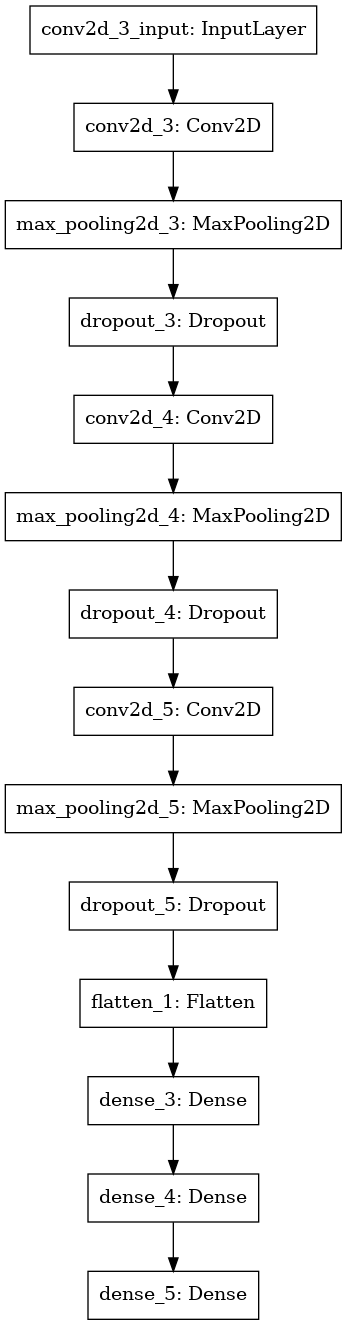

In [20]:
keras.utils.plot_model(model, "tomato_disease_model.png", show_shapes=False)

## Compiling, defining early stopping callback and fitting the model 

In [21]:
# Specify the cost, optimization method and metrics to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(1e-3),
  metrics=['accuracy']
)

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [25]:
# fit the model
history = model.fit(
      training_set,
      validation_data=test_set,
      epochs=100,
      callbacks=[early_stopping]    
)

Epoch 1/100
313/313 [==============================] - 171s 546ms/step - loss: 2.0410 - accuracy: 0.2488 - val_loss: 1.0742 - val_accuracy: 0.6210
Epoch 2/100
313/313 [==============================] - 119s 380ms/step - loss: 0.9220 - accuracy: 0.6754 - val_loss: 0.7866 - val_accuracy: 0.7320
Epoch 3/100
313/313 [==============================] - 118s 375ms/step - loss: 0.6392 - accuracy: 0.7754 - val_loss: 0.6056 - val_accuracy: 0.7900
Epoch 4/100
313/313 [==============================] - 117s 374ms/step - loss: 0.5021 - accuracy: 0.8273 - val_loss: 0.5488 - val_accuracy: 0.8090
Epoch 5/100
313/313 [==============================] - 118s 376ms/step - loss: 0.4530 - accuracy: 0.8334 - val_loss: 1.3317 - val_accuracy: 0.6630
Epoch 6/100
313/313 [==============================] - 119s 382ms/step - loss: 0.3806 - accuracy: 0.8601 - val_loss: 0.3457 - val_accuracy: 0.8780
Epoch 7/100
313/313 [==============================] - 118s 378ms/step - loss: 0.3662 - accuracy: 0.8715 - val_loss: 0

## Save the model to .h5 file

In [26]:
model.save('tomato_disease_classification_model.h5')

# Plots and Predictions

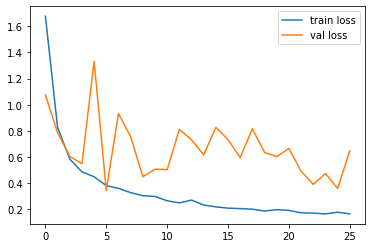

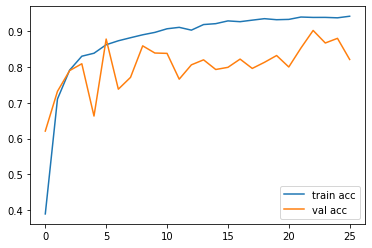

<Figure size 432x288 with 0 Axes>

In [27]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('train_and_validation_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('train_and_validation__accuracy')

In [28]:
model.evaluate(test_set)

32/32 [==============================] - 2s 77ms/step - loss: 0.3457 - accuracy: 0.8780


[0.3456888198852539, 0.878000020980835]

In [49]:
predictions= model.predict(test_set)
predictions_argmax=np.argmax(predictions,axis=1)

print(predictions_argmax.shape)
prediction_names=[CLASS_NAMES[i] for i in predictions_argmax]

(1000,)


In [62]:
# for batch in test_set:
#     print((batch[0]).shape)
#     print((batch[1]).shape)
#     break

In [61]:
# i=0
# for batch in test_set:
#     for ele in range((batch[0]).shape[0]):
#         plt.imshow(batch[0][ele])
#         print(np.argmax(batch[1][ele]))
#         print(predictions_argmax[i])
#         i=i+1
#         plt.show()
#         break
#     break